# Using causal-ccm to infer causality in time series data

In 2012, Sugihara et al. formulated the [Convergent Cross Mapping (CCM)](https://science.sciencemag.org/content/338/6106/496) methodology for inferring causality between elements in a complex system using just time-series data (no model of the system needed). 

In this notebook, we show an example how to use `causal-ccm` package to apply CCM on time series data.

## Installation
`pip install causal-ccm`

## Test Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # for showing progress bar in for loops

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r729kb50 because the default path (/home/ngerena/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
## Helper plotting function
def make_plots(df, dt_name, val1_name, val2_name):
    # drop nulls
    df = df[[dt_name, val1_name, val2_name]].dropna()
    
    # smoothen
    date_smooth = np.linspace(df[dt_name].min(), df[dt_name].max(), 100) 
    spl = make_interp_spline(df[dt_name], df[val1_name], k=2)
    val1 = spl(date_smooth)
    spl = make_interp_spline(df[dt_name], df[val2_name], k=2)
    val2 = spl(date_smooth)    
    r, p = np.round(pearsonr(df[val1_name], df[val2_name]), 4)
    
    # plot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_smooth, val1, )
    ax = df.plot(x=dt_name, y=val1_name, marker='', c='b', linestyle='', legend=False, ax=ax)
    ax.set_ylabel(val1_name)
    ax2 = ax.twinx()
    ax2.plot(date_smooth, val2, c='r')
    df.plot(x=dt_name, y=val2_name, marker='', c='r', linestyle='', legend=False, ax=ax2)
    ax2.set_ylabel(val2_name)    
    ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {r}", size=16)
    plt.tight_layout()
    plt.show()

## Sample CCM Usage

### Generate Dataset

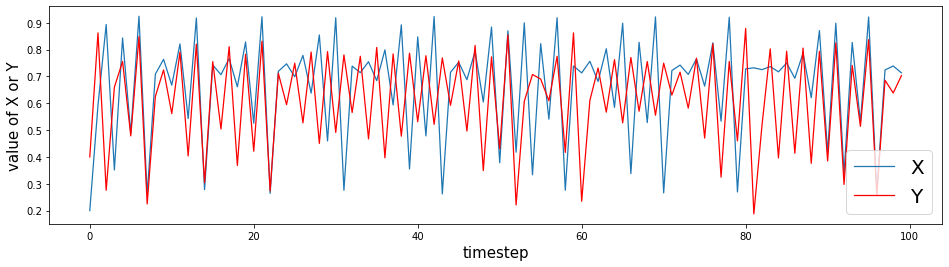

In [4]:
# Initialize test dataset

def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

# params
r_x = 3.7
r_y = 3.7
B_xy = 0 # effect on x given y (effect of y on x)
B_yx = 0.32 # effect on y given x (effect of x on y)

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 3000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)   
    
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})    

In [4]:
# !pip install causal-ccm

In [5]:
from causal_ccm.causal_ccm import ccm

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Checking X->Y

In [6]:
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X) # length of time period to consider

ccm1 = ccm(X, Y, tau, E, L)

In [7]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
ccm1.causality()

(0.9922458514060817, 0.0)

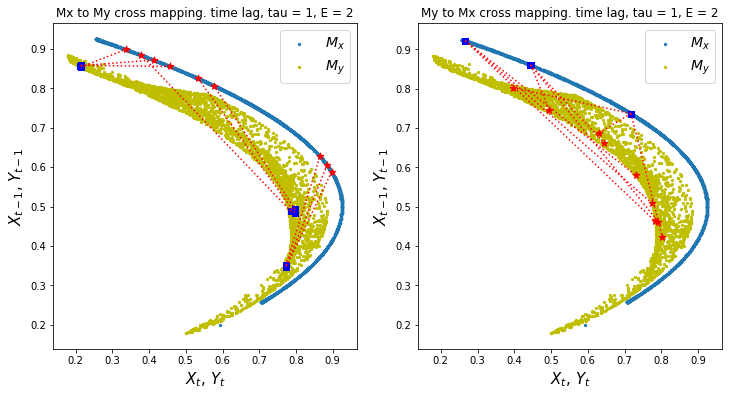

In [7]:
# visualize sample cross mapping
ccm1.visualize_cross_mapping()

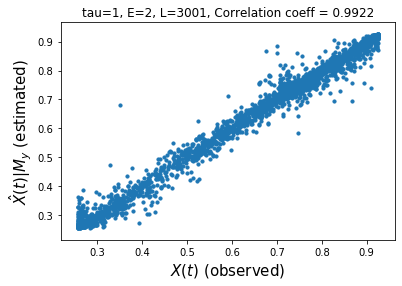

In [8]:
# Check correlation plot
ccm1.plot_ccm_correls() 

100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


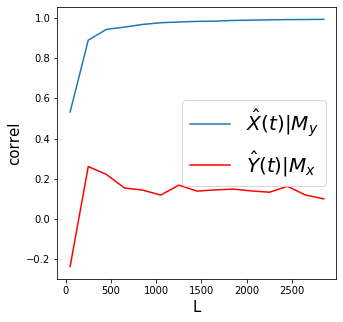

In [9]:
# checking convergence
# Looking at "convergence"
L_range = range(50, 3000, 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})    
    

In [1]:
from causal_ccm import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rgdonnan because the default path (/home/ngerena/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.stats import pearsonr


class ccm:
    """
    We're checking causality X -> Y       
    Args
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag. default = 1
        E: shadow manifold embedding dimension. default = 2
        L: time period/duration to consider (longer = more data). default = length of X
    """
    def __init__(self, X, Y, tau=1, E=2, L=None):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        if L == None:
            self.L = len(X)
        else:
            self.L = L
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold

    def shadow_manifold(self, V):
        """
        Given
            V: some time series vector
            tau: lag step
            E: shadow manifold embedding dimension
            L: max time step to consider - 1 (starts from 0)
        Returns
            {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
        """
        V = V[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
        for t in range((self.E-1) * self.tau, self.L):
            v_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
                v_lag.append(V[t-t2*self.tau])
            M[t] = v_lag
        return M

    # get pairwise distances between vectors in the time series
    def get_distances(self, M):
        """
        Args
            M: The shadow manifold from the time series
        Returns
            t_steps: timesteps
            dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
        """

        # we extract the time indices and vectors from the manifold M
        # we just want to be safe and convert the dictionary to a tuple (time, vector)
        # to preserve the time inds when we separate them
        t_vec = [(k, v) for k,v in M.items()]
        t_steps = np.array([i[0] for i in t_vec])
        vecs = np.array([i[1] for i in t_vec])
        dists = distance.cdist(vecs, vecs)
        return t_steps, dists

    def get_nearest_distances(self, t, t_steps, dists):
        """
        Args:
            t: timestep of vector whose nearest neighbors we want to compute
            t_teps: time steps of all vectors in the manifold M, output of get_distances()
            dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
            E: embedding dimension of shadow manifold M
        Returns:
            nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
            nearest_distances: array of distances corresponding to vectors closest to vector at time t
        """
        t_ind = np.where(t_steps == t) # get the index of time t
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)

        # get top closest vectors
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise
        nearest_distances = dist_t[nearest_inds]

        return nearest_timesteps, nearest_distances

    def predict(self, t):
        """
        Args
            t: timestep at manifold of y, My, to predict X at same time step
        Returns
            X_true: the true value of X at time t
            X_hat: the predicted value of X at time t using the manifold My
        """
        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)

        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)

        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat

    #     DEBUGGING
    #     will need to check why nearest_distances become nan
    #     if np.isnan(X_hat):
    #         print(nearest_timesteps)
    #         print(nearest_distances)

        return X_true, X_hat


    def causality(self):
        '''
        Args:
            None
        Returns:
            (r, p): how much X causes Y. as a correlation between predicted X and true X and the p-value (significance)
        '''

        # run over all timesteps in M
        # X causes Y, we can predict X using My
        # X puts some info into Y that we can use to reverse engineer X from Y via My
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat)

        x, y = X_true_list, X_hat_list
        r, p = pearsonr(x, y)

        return r, p

    def visualize_cross_mapping(self):
        """
        Visualize the shadow manifolds and some cross mappings
        """
        # we want to check cross mapping from Mx to My and My to Mx

        f, axs = plt.subplots(1, 2, figsize=(12, 6))

        for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
            #===============================================
            # Shadow Manifolds Visualization

            X_lag, Y_lag = [], []
            for t in range(1, len(self.X)):
                X_lag.append(self.X[t-self.tau])
                Y_lag.append(self.Y[t-self.tau])
            X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

            ax.scatter(X_t, X_lag, s=5, label='$M_x$')
            ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

            #===============================================
            # Cross Mapping Visualization

            A, B = [(self.Y, self.X), (self.X, self.Y)][i]
            cm_direction = ['Mx to My', 'My to Mx'][i]

            Ma = self.shadow_manifold(A)
            Mb = self.shadow_manifold(B)

            t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
            t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

            # Plot cross mapping for different time steps
            timesteps = list(Ma.keys())
            for t in np.random.choice(timesteps, size=3, replace=False):
                Ma_t = Ma[t]
                near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

                for i in range(self.E+1):
                    # points on Ma
                    A_t = Ma[near_t_A[i]][0]
                    A_lag = Ma[near_t_A[i]][1]
                    ax.scatter(A_t, A_lag, c='b', marker='s')

                    # corresponding points on Mb
                    B_t = Mb[near_t_A[i]][0]
                    B_lag = Mb[near_t_A[i]][1]
                    ax.scatter(B_t, B_lag, c='r', marker='*', s=50)

                    # connections
                    ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':')

            ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {self.tau}, E = 2')
            ax.legend(prop={'size': 14})

            ax.set_xlabel('$X_t$, $Y_t$', size=15)
            ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)
        plt.show()

    def plot_ccm_correls(self):
        """
        Args
            X: X time series
            Y: Y time series
            tau: time lag
            E: shadow manifold embedding dimension
            L: time duration
        Returns
            None. Just correlation plots between predicted X|M_y and true X
        """
        X_My_true, X_My_pred = [], []
        for t in range((self.E-1) * self.tau, self.L):
            true, pred = self.predict(t)
            X_My_true.append(true)
            X_My_pred.append(pred)

        # predicting X from My
        r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)

        plt.scatter(X_My_true, X_My_pred, s=10)
        plt.xlabel('$X(t)$ (observed)', size=15)
        plt.ylabel('$\hat{X}(t)|M_y$ (estimated)', size=15)
        plt.title(f'tau={self.tau}, E={self.E}, L={self.L}, Correlation coeff = {r}')

        plt.show()

        
class pai(ccm):
    
    def __init__(self, X, Y, tau=1, E=2, L=None):
        super().__init__(X, Y, tau, E, L)
        self.My = self.shadow_manifold(self.X) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold
        
    def shadow_manifold(self, V):
        
        """
        Given
            V: some time series vector
            W: the other time series vector
            tau: lag step
            E: shadow manifold embedding dimension
            L: max time step to consider - 1 (starts from 0)
        Returns
            {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
        """
        
        if self.X == V:
            W = self.Y
        else:
            W = self.X
            
        V = V[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
        for t in range((self.E-1) * self.tau, self.L):
            v_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
                v_lag.append(V[t-t2*self.tau])
            
            M[t] = v_lag + [W[t]]
        
    
        return M

    # get pairwise distances between vectors in the time series

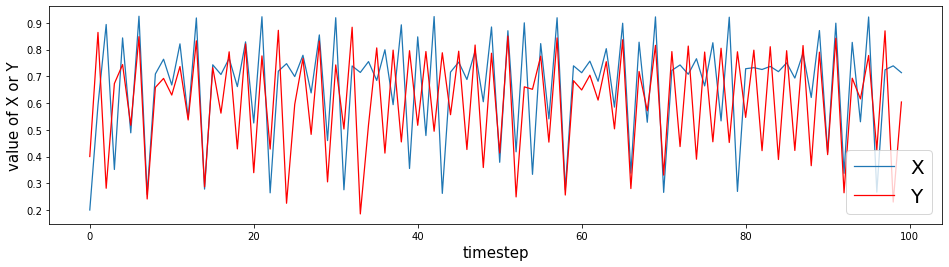

In [156]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)


# params
r_x = 3.7
r_y = 3.7
B_xy = 0.0 # effect on x given y (effect of y on x)
B_yx = 0.3 # effect on y given x (effect of x on y)

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 3000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)   
    
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})    

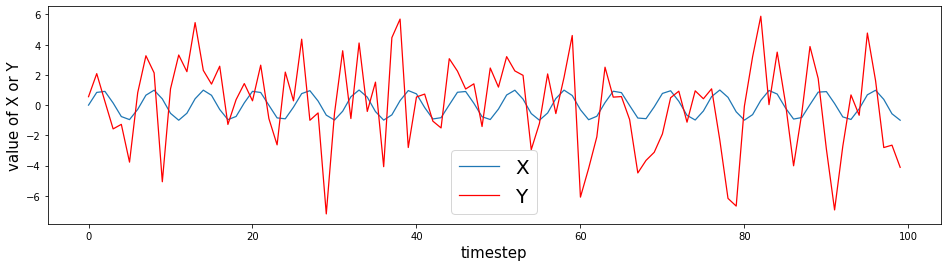

In [200]:
def generate_x_y(samples=4000, w=1, A=2.6, B=2.6):
    X = np.sin(np.arange(0,samples,1)*w)
    Y = A*X
    Y = Y + B*np.random.standard_normal(len(Y))
    return list(X[:-1]), list(Y[1:])
X, Y = generate_x_y()
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})    

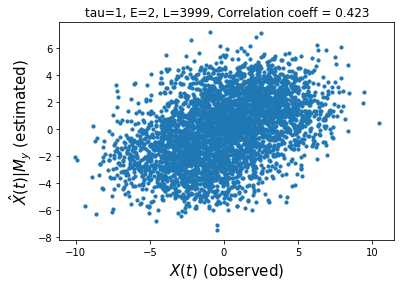

In [201]:
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X) # length of time period to consider

ccm1 = ccm(Y, X, tau, E, L)
ccm1.plot_ccm_correls()

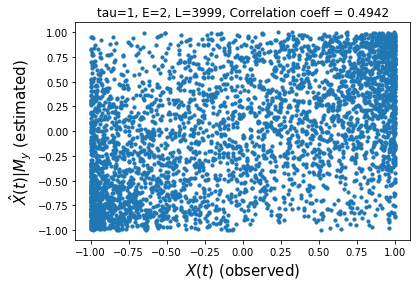

In [202]:
ccm1 = ccm(X, Y, tau, E, L)
ccm1.plot_ccm_correls()

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


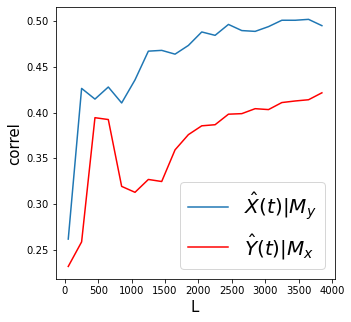

In [203]:
# checking convergence
# Looking at "convergence"
L_range = range(50, len(X), 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})

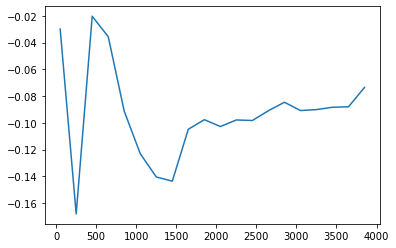

In [204]:
plt.plot(L_range, np.array(Yhat_Mx) - np.array(Xhat_My));

In [210]:
B

0.0

In [212]:
As.index(1)

2

In [ ]:
from itertools import product
As= list(np.arange(0, 10, 0.2))
Bs = list(np.arange(0, 10, 0.2))

AB = list(set(product(As, Bs)))
deltas = []
matrix = np.zeros((len(As),len(Bs)))
for A, B in AB:
    X, Y = generate_x_y(samples=2000, w=1, A=A, B=B)
    ccm1 = ccm(X, Y, tau=1, E=2)
    Cxy = ccm1.causality()[0]
    ccm1 = ccm(Y, X, tau=1, E=2)
    Cyx = ccm1.causality()[0]
    matrix[As.index(A),Bs.index(B)] = Cyx - Cxy
    deltas.append(Cyx - Cxy)

In [ ]:
plt.figure(figsize=(5, 5))
plt.matshow(matrix > 0, origin='lower', cmap='jet', fignum=1)
plt.xlabel('B', size=12)
plt.ylabel('A', size=12)
plt.colorbar()
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


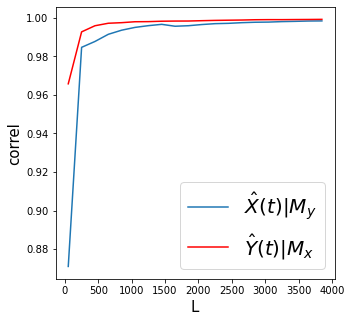

In [192]:
# checking convergence
# Looking at "convergence"
L_range = range(50, len(X), 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = pai(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = pai(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})

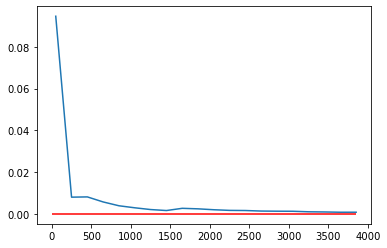

In [193]:
plt.plot(L_range, np.array(Yhat_Mx) - np.array(Xhat_My));
#plt.ylim(-0.001, 0.001)
plt.hlines(0, 0, L, color='r')

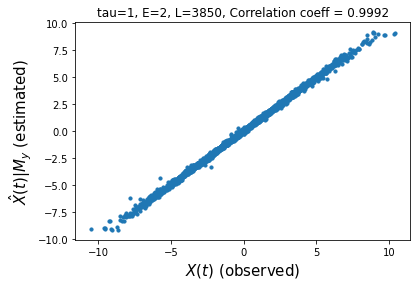

In [194]:
ccm1 = pai(Y, X, tau, E, L)
ccm1.plot_ccm_correls()

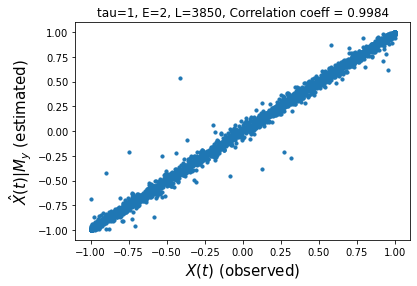

In [195]:
ccm1 = pai(X, Y, tau, E, L)
ccm1.plot_ccm_correls()

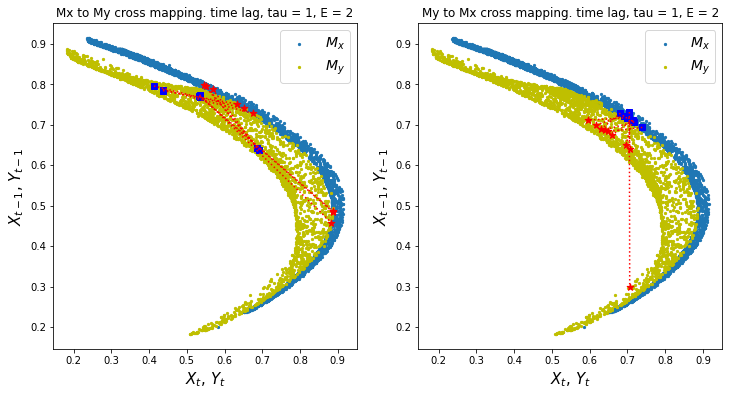

In [199]:
ccm1 = pai(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()